# Zjawisko niepewności w sieciach neuronowych
Dotyczy wpływu małych perturbacji na działanie i skuteczne przewidywania naszego modelu. W artykule https://arxiv.org/abs/1901.07152 przedstawione są 3 sposoby wprowadzania takowych zniekształceń. Należą do nich zmiany trenowalnych parametrów jednej lub wszystkich warstw oraz 'zaszumienie' danych wejściowych.

In [45]:
import numpy as np
import keras
import tensorflow as tf
from keras.metrics import TruePositives
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras import backend as K
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dane i model
Dane którymi będę się posługiwać jest dobrze znany i lubiany zbiór CIFAR10

In [46]:
(X_train,y_train), (X_test,y_test) = cifar10.load_data()

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
X_test = X_test /255
X_train = X_train /255

Źródło modelu: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)       

In [48]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,epochs = 10)

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.9549 - accuracy: 0.3635
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1180 - accuracy: 0.6081
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9225 - accuracy: 0.6805
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8140 - accuracy: 0.7192
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7316 - accuracy: 0.7491
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6736 - accuracy: 0.7704
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6299 - accuracy: 0.7840
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5859 - accuracy: 0.7997
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5525 - accuracy: 0.8111
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - l

Tutaj sprawdzamy jak nasz model sobie radzi przed wprowadzeniem jakichkolwiek zmian oraz zapisujemy wszystie wytrenowane parametry.

In [64]:
layers_weights=[]
for layer in model.layers:
  layers_weights.append(layer.get_weights())
row=model.evaluate(X_test,y_test)
data=pd.DataFrame(data=[row],columns=["Loss","Accuracy"])
data

313/313 [==============================] - 1s 3ms/step - loss: 0.5160 - accuracy: 0.8260


,Loss,Accuracy
0,0.516018,0.826


Funkcja do wczytania oryginalnych wag modelu

In [50]:
def original_model(layers_weights):
  for j in range(0,23):
    if j in [4,5,10,11,16,17,18,21]: #warstwy bez parametrów
      continue
    elif j in [1,3,7,9,13,15,20]: #batch normalization
      model.layers[j].set_weights([layers_weights[j][0],
                                   layers_weights[j][1],
                                   layers_weights[j][2],
                                   layers_weights[j][3]])
    else:                         #conv2D i dense
      model.layers[j].set_weights([layers_weights[j][0],
                                   layers_weights[j][1]])

# Zmiana wag jednej warstwy

Pierwszy test bedzie dotyczył zmian w wagach i biasach warstwy Dense. Każda z nich zostanie losowo pomnożona przez liczbę z zakresu [0.1,10]. Eksperyment zostanie powtórzony 50 razy.

In [51]:
original_model(layers_weights)
rows=[]
for i in range(1,51):
  model.layers[19].set_weights([layers_weights[19][0]*np.random.uniform(low=0.1,high=10,size=(2048,128)),
                                layers_weights[19][1]*np.random.uniform(low=0.1,high=10,size=128)])
  print(i)
  row=model.evaluate(X_test,y_test)
  rows.append(row)
data=pd.DataFrame(data=rows,columns=["Loss","Accuracy"])

1
313/313 [==============================] - 1s 3ms/step - loss: 1.9828 - accuracy: 0.7948
2
313/313 [==============================] - 1s 3ms/step - loss: 1.9961 - accuracy: 0.7952
3
313/313 [==============================] - 1s 3ms/step - loss: 1.9434 - accuracy: 0.7974
4
313/313 [==============================] - 1s 3ms/step - loss: 1.9913 - accuracy: 0.7959
5
313/313 [==============================] - 1s 3ms/step - loss: 1.9586 - accuracy: 0.7982
6
313/313 [==============================] - 1s 3ms/step - loss: 1.9397 - accuracy: 0.7984
7
313/313 [==============================] - 1s 3ms/step - loss: 1.9821 - accuracy: 0.7958
8
313/313 [==============================] - 1s 3ms/step - loss: 2.0035 - accuracy: 0.7939
9
313/313 [==============================] - 1s 3ms/step - loss: 2.0055 - accuracy: 0.7969
10
313/313 [==============================] - 1s 3ms/step - loss: 1.9457 - accuracy: 0.7963
11
313/313 [==============================] - 1s 3ms/step - loss: 2.0182 - accuracy: 0.79

In [52]:
a=data.std(axis=0).to_numpy()
b=data.mean(axis=0).to_numpy()
pd.DataFrame([a,b],index=["Std","Mean"],columns=["Loss","Accuracy"])

,Loss,Accuracy
Std,0.025147,0.001658
Mean,1.982403,0.795564


Mimo możliwych dużych różnic w wagach i biasach accuracy tylko trochę się pogorszyło.

Sprawdźmy teraz czy otrzymamy podobny wynik zmieniając w ten sam sposób parametry warstwy konwolucyjnej.

In [53]:
original_model(layers_weights)
rows=[]
low=0.1
high=10
for i in range(1,51):
  size1=layers_weights[2][0].shape
  size2=layers_weights[2][1].shape
  model.layers[2].set_weights([layers_weights[2][0]*np.random.uniform(low=low,high=high,size=size1),
                               layers_weights[2][1]*np.random.uniform(low=low,high=high,size=size2)])
  print(i)
  row=model.evaluate(X_test,y_test)
  rows.append(row)
data=pd.DataFrame(data=rows,columns=["Loss","Accuracy"])

1
313/313 [==============================] - 1s 3ms/step - loss: 2.4623 - accuracy: 0.4864
2
313/313 [==============================] - 1s 3ms/step - loss: 2.3922 - accuracy: 0.5356
3
313/313 [==============================] - 1s 3ms/step - loss: 2.2830 - accuracy: 0.5252
4
313/313 [==============================] - 1s 3ms/step - loss: 2.2892 - accuracy: 0.5198
5
313/313 [==============================] - 1s 3ms/step - loss: 2.6273 - accuracy: 0.5013
6
313/313 [==============================] - 1s 3ms/step - loss: 2.3530 - accuracy: 0.5235
7
313/313 [==============================] - 1s 3ms/step - loss: 3.7184 - accuracy: 0.4171
8
313/313 [==============================] - 1s 3ms/step - loss: 2.3994 - accuracy: 0.4919
9
313/313 [==============================] - 1s 3ms/step - loss: 2.6893 - accuracy: 0.4778
10
313/313 [==============================] - 1s 3ms/step - loss: 2.4973 - accuracy: 0.5072
11
313/313 [==============================] - 1s 3ms/step - loss: 2.6419 - accuracy: 0.48

In [54]:
a=data.std(axis=0).to_numpy()
b=data.mean(axis=0).to_numpy()
pd.DataFrame([a,b],index=["Std","Mean"],columns=["Loss","Accuracy"])

,Loss,Accuracy
Std,0.358715,0.030121
Mean,2.628953,0.493410


Średnie accuracy pogorszyło się tym razem znacząco. Również odchylenie standardowe wzrosło w porównaniu do poprzedniego przykładu. Różnica może wynikać z umiejscowienia tych warstw w sieci. Mam przez to na myśli, że znaczenie błędów powstałych w warstwie konwolucyjnej na początku urosło wraz z każdą kolejną warstwą powodując duże różnice na wyjściu.

# Zmiana wag wszystkich warstwy

Tym razem będziemy mnożyć wszystkie trenowalne parametry przez liczby losowane z zakresu [0.7,1.2]. Zakres został znacznie zmniejszony ponieważ ilość parametrów, na które wpływamy tym razem jest dużo większa.

In [55]:
original_model(layers_weights)
rows=[]
low=0.7
high=1.2
for i in range(1,51):
  original_model(layers_weights)
  for j in range(0,23):
    if j in [4,5,10,11,16,17,18,21]: #warstwy bez parametrów
      continue

    elif j in [1,3,7,9,13,15,20]: #batch normalization
      size1=layers_weights[j][0].shape
      size2=layers_weights[j][1].shape
      size3=layers_weights[j][2].shape
      size4=layers_weights[j][3].shape
      model.layers[j].set_weights([layers_weights[j][0]*np.random.uniform(low=low,high=high,size=size1),
                                   layers_weights[j][1]*np.random.uniform(low=low,high=high,size=size2),
                                   layers_weights[j][2]*np.random.uniform(low=low,high=high,size=size3),
                                   layers_weights[j][3]*np.random.uniform(low=low,high=high,size=size4)])
      
    else:                         #conv2D i dense
      size1=layers_weights[j][0].shape
      size2=layers_weights[j][1].shape
      model.layers[j].set_weights([layers_weights[j][0]*np.random.uniform(low=low,high=high,size=size1),
                                   layers_weights[j][1]*np.random.uniform(low=low,high=high,size=size2)])
  print(i)
  row=model.evaluate(X_test,y_test)
  rows.append(row)
data=pd.DataFrame(data=rows,columns=["Loss","Accuracy"])

1
313/313 [==============================] - 1s 3ms/step - loss: 1.0117 - accuracy: 0.6517
2
313/313 [==============================] - 1s 3ms/step - loss: 0.7819 - accuracy: 0.7313
3
313/313 [==============================] - 1s 3ms/step - loss: 1.0617 - accuracy: 0.6365
4
313/313 [==============================] - 1s 3ms/step - loss: 1.4278 - accuracy: 0.5183
5
313/313 [==============================] - 1s 3ms/step - loss: 0.9721 - accuracy: 0.6672
6
313/313 [==============================] - 1s 3ms/step - loss: 1.9674 - accuracy: 0.4092
7
313/313 [==============================] - 1s 3ms/step - loss: 1.1241 - accuracy: 0.6216
8
313/313 [==============================] - 1s 3ms/step - loss: 0.7508 - accuracy: 0.7512
9
313/313 [==============================] - 1s 3ms/step - loss: 1.0746 - accuracy: 0.6338
10
313/313 [==============================] - 1s 3ms/step - loss: 1.3939 - accuracy: 0.5766
11
313/313 [==============================] - 1s 3ms/step - loss: 2.4086 - accuracy: 0.35

In [56]:
a=data.std(axis=0).to_numpy()
b=data.mean(axis=0).to_numpy()
pd.DataFrame([a,b],index=["Std","Mean"],columns=["Loss","Accuracy"])

,Loss,Accuracy
Std,0.365832,0.103849
Mean,1.144072,0.620968


W tym przypadku również widzimy spory spadek accuracy oraz większe niż w poprzednich przypadkach odchylenie standardowe.

# Perturbacja danych wejściowych

Każdy piksel zostanie pomnożony przez losową liczbę z zakresu [0.7,1.2].

In [57]:
rows=[]
original_model(layers_weights)
for i in range(1,50):
  original_model(layers_weights)
  test_images = [img*np.random.uniform(low=0.7,high=1.2,size=(10000, 32, 32, 3)) for img in [X_test]]
  row=[i/10]+model.evaluate(test_images,y_test)
  rows.append(row)
data=pd.DataFrame(data=rows,columns=['i','Loss','Accuracy'])

313/313 [==============================] - 1s 4ms/step - loss: 2.1378 - accuracy: 0.4183


Porównanie obrazków.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


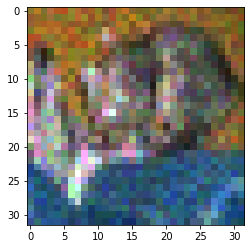

In [58]:
plt.imshow(test_images[0][0])

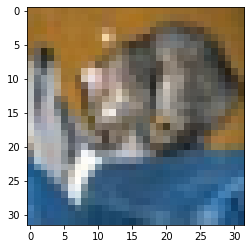

In [59]:
plt.imshow(X_test[0])

In [60]:
a=data.std(axis=0).to_numpy()[1:]
b=data.mean(axis=0).to_numpy()[1:]
pd.DataFrame([a,b],index=["Std","Mean"],columns=["Loss","Accuracy"])

,Loss,Accuracy
Std,0.004829,0.002026
Mean,2.143682,0.418078


Wprowadzone perturbacje wyraźnie pogorszyły trafność modelu ale ciekawe jest to, że tym razem odchylenie standardowe nie jest zauważalnie duże.

# Podsumowanie
Największą różnicę w wynikach uzyskałem wprowadzjąc szum do danych wejściowych. Jeśli model nie uczył się na zaszumionych danych to ma to jak najbardziej sens. Również perturbację w początkowych warstwach bardzo negatywnie odbijają się na całym modelu, ponieważ tak jak wspomniałem wcześniej znaczenie tego błędu może nabierać na sile przy przechodzeniu przez kolejne warstwy